# Perceptual distance

**Run notebook online with Binder:** [![Binder](http://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LabForComputationalVision/plenoptic/master?filepath=examples/04_Perceptual_distance.ipynb)

This tutorial introduces the four perceptual distance functions available in `plenoptic` package: SSIM (structural similarity), MS-SSIM (multiscale structural similarity), NLPD (normalized Laplacian pyramid distance) and NSPD (normalized steerable pyramid distance).

In [1]:
import io
import imageio
import plenoptic as po
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## SSIM (structural similarity)

The idea of SSIM index is to decompose the difference between two images into three components: luminance, contrast, and structure. For two small image patches $\mathbf{x}$ and $\mathbf{y}$, these three components of difference are defined as:
$$ l(\mathbf{x}, \mathbf{y}) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}, \qquad
c(\mathbf{x}, \mathbf{y}) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}, \qquad
s(\mathbf{x}, \mathbf{y}) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3} $$
where $\mu_x$ and $\mu_y$ are the mean of $\mathbf{x}$ and $\mathbf{y}$, $\sigma_x$ and $\sigma_y$ are the standard deviation of $\mathbf{x}$ and $\mathbf{y}$, and $\sigma_{xy}$ is the covariance between $\mathbf{x}$ and $\mathbf{y}$. And $C_1, C_2, C_3$ are small constants. If we ignore the small constants, we can see that the luminance term $l(\mathbf{x}, \mathbf{y})$ is a scale-invariant similarity measurement between $\mu_x$ and $\mu_y$, and the contrast term $c(\mathbf{x}, \mathbf{y})$ is such a measurement between $\sigma_x$ and $\sigma_y$. The structural term $s(\mathbf{x}, \mathbf{y})$ is the correlation coefficient between $\mathbf{x}$ and $\mathbf{y}$, which is invariant to addition and multiplication of constants on $\mathbf{x}$ or $\mathbf{y}$.

SSIM between two small image patches $\mathbf{x}$ and $\mathbf{y}$ is defined as (let $C_3 = C_2 / 2$):
$$ \text{SSIM}(\mathbf{x}, \mathbf{y}) = l(\mathbf{x}, \mathbf{y}) c(\mathbf{x}, \mathbf{y}) s(\mathbf{x}, \mathbf{y}) = \frac{(2 \mu_x \mu_y + C_1)(2\sigma_{xy} + C_2)} {(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)} $$
An SSIM value of 1 means the two patches are identical and 0 means they're very different. When the two patches are negatively correlated, SSIM can be negative. SSIM is bounded between -1 and 1.

For two full images, an SSIM map is obtained by computing this local SSIM value across the whole image. The local mean, variance and covariance terms are computed by sliding a circular-symmetric Gaussian kernel across the image, instead of in a square image patch (which is equivalent to using a square-shaped kernel filled with ones). The values in the SSIM map are averaged to generate a single number, which is the SSIM index. It is also bounded between -1 and 1.  In `plenoptic`, the SSIM map is computed by the function `po.metric.ssim_map`, and the SSIM index itself is computed by the function `po.metric.ssim`. For more information, see the original paper:

Zhou Wang, A. C. Bovik, H. R. Sheikh and E. P. Simoncelli, "Image quality assessment: from error visibility to structural similarity," in _IEEE Transactions on Image Processing_, vol. 13, no. 4, pp. 600-612, April 2004.

The easiest way to compute the difference between two images is mean square error (MSE), but it does not match the perceptual distance judged by humans. We demonstrate the effectiveness of SSIM by generating five different types of distortions (contrast stretching, mean shifting, JPEG compression, blurring, and salt-pepper noise) with the same MSE, and compute their SSIM values.

In [2]:
def add_jpeg_artifact(img, quality):
    img = (img * 255).astype(np.uint8)
    buffer = io.BytesIO()
    imageio.imwrite(buffer, img, format="jpg", quality=quality)
    return imageio.imread(buffer.getbuffer(), format="jpg").astype(float) / 255

In [3]:
def add_saltpepper_noise(img, threshold):
    np.random.seed(0)
    img_saltpepper = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x = np.random.rand()
            if x < threshold:
                img_saltpepper[i, j] = 0
            elif x > 1 - threshold:
                img_saltpepper[i, j] = 1
    np.random.seed(None)
    return img_saltpepper

In [4]:
def get_distorted_images():
    img = plt.imread("../data/256/einstein.pgm").astype(float) / 255
    img_contrast = np.clip(img + 0.20515 * (2 * img - 1), a_min=0, a_max=1)
    img_mean = np.clip(img + 0.05983, a_min=0, a_max=1)
    img_jpeg = add_jpeg_artifact(img, quality=4)
    img_blur = gaussian_filter(img, sigma=1.983)
    img_saltpepper = add_saltpepper_noise(img, threshold=0.00651)
    img_distorted = torch.tensor([img, img_contrast, img_mean, img_jpeg, img_blur, img_saltpepper], dtype=torch.float32).unsqueeze(1)
    # TODO: device GPU
    return img_distorted

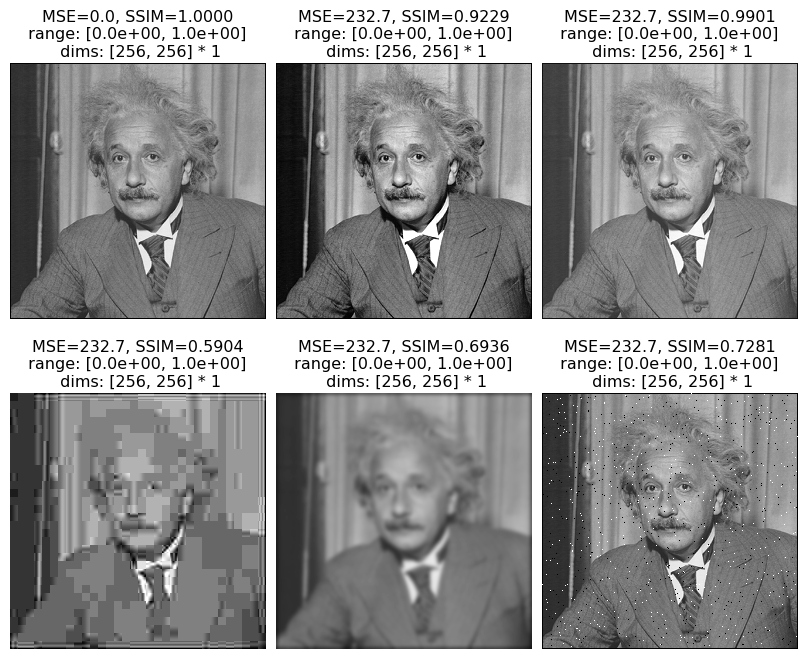

In [5]:
img_distorted = get_distorted_images()
mse_values = torch.square(img_distorted - img_distorted[0]).mean(dim=(1, 2, 3)) * 255**2
ssim_values = po.metric.ssim(img_distorted, img_distorted[[0]])[:, 0]
titles = [f"MSE={mse_values[i]:.1f}, SSIM={ssim_values[i]:.4f}" for i in range(6)]
po.imshow(img_distorted, vrange="auto", title=titles, col_wrap=3);

We can see that the SSIM index matches human perception better than MSE.

While the scalar SSIM index is a concise summary, the SSIM map offers richer information about where perceptual discrepancy is located in the image. Here, we visualize the SSIM map of a JPEG compressed image, and also show the absolute error (absolute value of the difference) for comparison. In both maps, darker means more different.

In [6]:
def get_demo_images():
    img = plt.imread("../data/Parrot.png").astype(float)
    img_jpeg = add_jpeg_artifact(img, quality=6)
    img = torch.tensor(img, dtype=torch.float32)[None, None]
    img_jpeg = torch.tensor(img_jpeg, dtype=torch.float32)[None, None]
    ssim_map_small = po.metric.ssim_map(img, img_jpeg)
    ssim_map = torch.ones_like(img)
    ssim_map[:, :, 5:-5, 5:-5] = ssim_map_small
    abs_map = 1 - torch.abs(img - img_jpeg)
    img_demo = torch.cat([img, img_jpeg, ssim_map, abs_map], dim=0)
    return img_demo

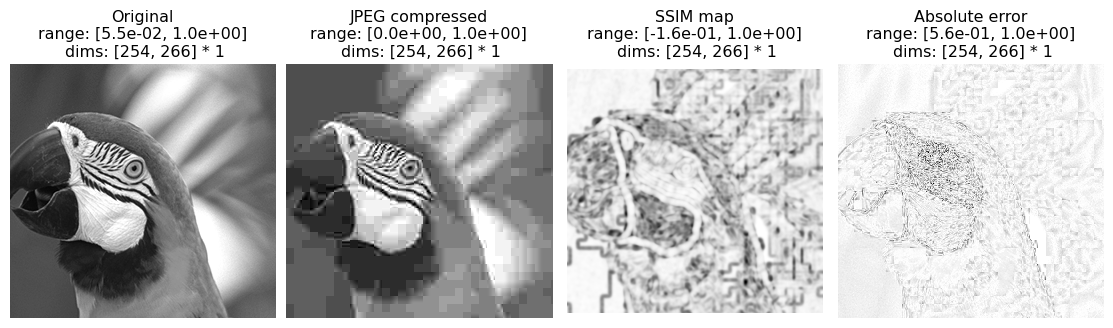

In [7]:
img_demo = get_demo_images()
titles = ["Original", "JPEG compressed", "SSIM map", "Absolute error"]
po.imshow(img_demo, title=titles);

You can judge whether the SSIM map captures the location of perceptual discrepancy better than absolute error.